In [1]:
from time import sleep
import matplotlib.pyplot as plt

%matplotlib inline



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from pettingzoo.classic import connect_four_v3

import pygame

In [2]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cpu'

In [3]:
env = connect_four_v3.env(render_mode="human")
#env = connect_four_v3.env()
env.reset()


#Numero de iteraciones
num_episodes = 500

In [4]:
# Definicion de variables
GAMMA = 0.99
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = 0.0001
TAU = 0.0005
LR = 3e-3

# Get number of actions from gym action space
n_actions = 7

# Get the number of state observations
observation, reward, termination, truncation, info = env.last()

#observation_shape = np.array(observation["observation"]).reshape(1,-1)
n_observations = 84

In [5]:
class ActorNetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(ActorNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class CriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

class SAC:
    def __init__(self,name,lr,gamma,tau, eps_start,eps_end,eps_dec, n_observations,n_actions):

        self.name = name
        
        self.lr = lr
        self.gamma = gamma
        self.tau = tau
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_dec = eps_dec

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.n_observations = n_observations
        self.n_actions = n_actions

        self.policy_net = ActorNetwork(n_observations, n_actions).to(self.device)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr, amsgrad=True)

        self.critic_net_1 = CriticNetwork(n_observations, n_actions).to(self.device)
        self.critic_optimizer_1 = optim.Adam(self.critic_net_1.parameters(), lr=self.lr, amsgrad=True)
        self.critic_net_2 = CriticNetwork(n_observations, n_actions).to(self.device)
        self.critic_optimizer_2 = optim.Adam(self.critic_net_2.parameters(), lr=self.lr, amsgrad=True)

        self.target_net_1 = CriticNetwork(n_observations, n_actions).to(self.device)
        self.target_optimizer_1 = optim.Adam(self.target_net_1.parameters(), lr=self.lr, amsgrad=True)
        self.target_net_2 = CriticNetwork(n_observations, n_actions).to(self.device)
        self.target_optimizer_2 = optim.Adam(self.target_net_2.parameters(), lr=self.lr, amsgrad=True)


        self.memory = []

        self.value_criterion = nn.MSELoss()
        self.criterion_1 = nn.MSELoss()
        self.criterion_2 = nn.MSELoss()
        self.probs = []
        self.loss = 0




    def choose_action(self, agent, state, env):
        if np.random.random() < self.epsilon:
            action = env.action_space(agent).sample(state["action_mask"])
        else:
            action_mask = torch.tensor(state["action_mask"])
            state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
            
            q_values = self.policy_net(state_tensor)
            max, min= torch.max(q_values), torch.min(q_values)
            q_values = (q_values-min) / (max-min)
            valid_actions = action_mask *  q_values

            print(valid_actions)
            
            # self.probs = valid_actions

            action = np.argmax(valid_actions.detach().numpy())


            #self.policy_net.train()
            self.decrement_epsilon()

        return action
    
    def update(self, state, new_state, reward,done):
        
        
        
        state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
        new_state_tensor = torch.FloatTensor(np.array(new_state["observation"]).reshape(1,-1))

        next_action_prob = self.policy_net(state_tensor)


        next_q_target_1 = self.target_net_1(new_state_tensor)
        next_q_target_2 = self.target_net_2(new_state_tensor)

        min_next_q_target = torch.min(next_q_target_1, next_q_target_2)
        next_q = (100 * reward) + (1 - done) * self.gamma * (min_next_q_target - next_action_prob)

        Value_1 = self.critic_net_1(state_tensor)  # Doble calculo de la Q-Network
        value_2 = self.critic_net_2(state_tensor)

        loss_1 = self.criterion_1(Value_1,next_q)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        loss_2 = self.criterion_2(value_2,next_q)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]

        self.loss = (loss_1 + loss_2)/2  # Promedio de la funcion de perdida

        self.policy_optimizer.zero_grad()
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        self.target_optimizer_1.zero_grad()
        self.target_optimizer_2.zero_grad()

        self.loss.backward()
        
        self.policy_optimizer.step()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()
        self.target_optimizer_1.step()
        self.target_optimizer_2.step()




    def update_memory(self,state, reward, termination, truncation, info):
        self.memory.append((state, reward, termination, truncation, info))

    def clear_memory(self):
        self.memory = []


    def optimize(self):
        self.policy_optimizer.zero_grad()
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        self.target_optimizer_1.zero_grad()
        self.target_optimizer_2.zero_grad()
        
        self.policy_optimizer.step()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()
        self.target_optimizer_1.step()
        self.target_optimizer_2.step()
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_end else self.eps_end
        

    def save_model(self):

        # Path para guardar los agentes entrenados
        PATH = "Agents/" + self.name + ".pt"

        torch.save({
                    'policy_net': self.policy_net.state_dict(),
                    'critic_net_1': self.critic_net_1.state_dict(),
                    'critic_net_2': self.critic_net_2.state_dict(),
                    'target_net_1': self.target_net_1.state_dict(),
                    'target_net_2': self.target_net_2.state_dict(),
                    }, PATH)
    
    def load_model(self):

        # Path donde se encuentran los agentes entrenados
        PATH = "Agents/" + self.name + ".pt"

        checkpoint = torch.load(PATH)

        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.critic_net_1.load_state_dict(checkpoint['critic_net_1'])
        self.critic_net_2.load_state_dict(checkpoint['critic_net_2'])
        self.target_net_1.load_state_dict(checkpoint['target_net_1'])
        self.target_net_2.load_state_dict(checkpoint['target_net_2'])

        self.policy_net.eval()
        self.critic_net_1.eval()
        self.critic_net_2.eval()
        self.target_net_1.eval()
        self.target_net_2.eval()

In [6]:
# Creamos las 3 instancias

sac_agent_0 = SAC(name="agent_0", lr=LR,gamma=GAMMA,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)

sac_agent_1 = SAC(name="agent_1", lr=LR,gamma=GAMMA,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)

sac_agent_a = SAC(name="agent_a", lr=LR,gamma=GAMMA,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)

In [7]:
##Cargamos los agentes entrenados

sac_agent_0.load_model()
sac_agent_1.load_model()
sac_agent_a.load_model()

In [8]:
# Creamos el primer entorno

agent_0_score = []
agent_a_score = []



total_reward_player_0 = 0
total_reward_player_a = 0
last_action_player_0 = 0
last_action_player_a = 0

env.reset()
observation, reward, termination, truncation, info = env.last()
previous_state = observation

for episode in range(num_episodes):
    state = env.reset()
    env.render()
    
    #Definicion del primer jugador en cada partida
    if(episode % 2 == 1):
        for agent in env.agent_iter():
            
            state, reward, termination, truncation, info = env.last()

            if(agent == "player_0"):
                action = sac_agent_1.choose_action(agent,state,env)
            else:
                action = sac_agent_a.choose_action(agent,state,env)
            
            env.step(action) 

            previous_state = state
            state, reward, termination, truncation, info = env.last()
            
            if termination or truncation:
                    # Registramos las recompensas
                    total_reward_player_0 = total_reward_player_0 + env.rewards["player_0"]
                    total_reward_player_a = total_reward_player_a + env.rewards["player_1"]

                    agent_0_score.append(total_reward_player_0)
                    agent_a_score.append(total_reward_player_a)

                    break
        env.close()
    else:
        for agent in env.agent_iter():
            #print(agent)
            state, reward, termination, truncation, info = env.last()

            if(agent == "player_1"):
                action = sac_agent_0.choose_action(agent,state,env)
            else:
                action = sac_agent_a.choose_action(agent,state,env)
            
            env.step(action) 
            
            previous_state = state
            state, reward, termination, truncation, info = env.last()


            if termination or truncation:
                    #print(env.rewards)
                    total_reward_player_0 = total_reward_player_0 + env.rewards["player_1"]
                    total_reward_player_a = total_reward_player_a + env.rewards["player_0"]

                    agent_0_score.append(total_reward_player_0)
                    agent_a_score.append(total_reward_player_a)

                    break
        env.close()
    #sleep(0.5)


print("Total score Competitive SAC Agent: " + str(total_reward_player_0))
print("Total score Alone SAC Agent: " + str(total_reward_player_a))

tensor([[0.7471, 0.5551, 0.2863, 0.6649, 1.0000, 0.3746, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.9444, 0.5897, 0.3046, 0.7325, 1.0000, 0.0941, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.6233, 1.0000, 0.9729, 0.0000, 0.2737, 0.8420, 0.7674]],
       grad_fn=<MulBackward0>)
tensor([[0.5602, 1.0000, 0.9378, 0.0000, 0.2176, 0.9734, 0.8713]],
       grad_fn=<MulBackward0>)
tensor([[0.5533, 1.0000, 0.9484, 0.0000, 0.2188, 0.9077, 0.8441]],
       grad_fn=<MulBackward0>)
tensor([[0.4395, 0.4002, 0.2080, 0.6422, 1.0000, 0.6351, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.5375, 0.9673, 1.0000, 0.0000, 0.2914, 0.7605, 0.7887]],
       grad_fn=<MulBackward0>)
tensor([[0.5123, 0.4589, 0.3559, 0.6552, 1.0000, 0.5619, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.6498, 0.0000, 0.5024, 0.4991, 0.3082, 1.0000, 0.7247]],
       grad_fn=<MulBackward0>)
tensor([[0.7067, 0.0000, 0.6250, 0.4489, 0.2323, 1.0000, 0.6173]],
       grad_fn=<MulBackward0>)
tensor([[0.4755, 0.9

KeyboardInterrupt: 

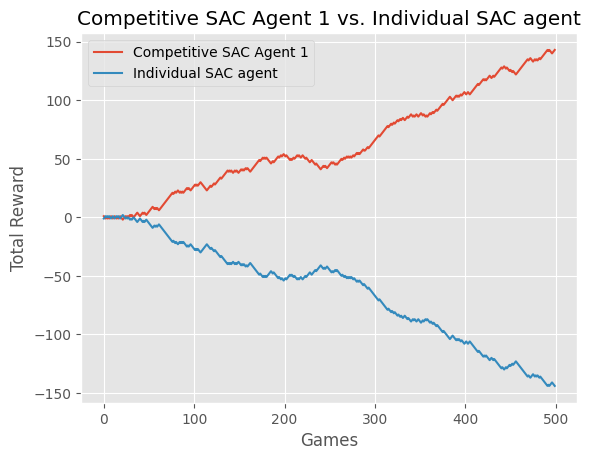

In [ ]:
plt.title("Competitive SAC Agent 1 vs. Individual SAC agent")

plt.ylabel("Total Reward")
plt.xlabel("Games")

plt.style.use("ggplot")
plt.plot(agent_0_score, label="Competitive SAC Agent 1")
plt.plot(agent_a_score, label="Individual SAC agent")

plt.legend()
plt.show()